In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import partial

from tqdm.notebook import tqdm, trange

from depth_Functions import (
    show_img,
    show_array_of_images,
    show_function,
    import_raw_colour_image,
    import_raw_depth_image
)

from Feature_Extraction import *

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

from Global import *

from Laplacian import Laplacian

# 3-D Depth Reconstruction from a Single Still Image using Markov Random Field

This implementation is predominantly based on [Saxena, A., Chung, S.H. and Ng, A.Y., 2008. 3-D depth reconstruction from a single still image. International journal of computer vision, 76(1), pp.53-69.](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf).

The theory is that we the best features to approximate the depth of an image are the textures features, which are obtained from the texture of the image. These features are converted into a single value that represents depth by carrying out a dot product with an array of weights. These weights are determined via least squares calculation between the features and known depth values. There exists a natural difference between the correlation between depth and texture at different heights in an image, for example the sky and sea will have similar textures but significantly differing expected depths. To account for this each row, or group of rows, are given idependant weights.

To provide further accuracy inspiration is taken from the way the human eye incorporates the estimated depth surrounding an object. A more accurate approximation is obtained when incorporating the depths surrounding a pixel, the depth at different scales and the relative depth between a patch of pixels and its neighbours.

This implementation looked to provide a more pythonic implementation of the original method alongside a version that provides a pixel level of definition. This was achieved up to a level that incorporated absolute and neighbour depth. At time of submission the methods for incorporating the depth at larger scales and relative depth have not been successfully included in the implementation to provide a more accurate result than was obtained without.

### Feature Extraction

We obtain a vector of length 34. A standard and squared version of:

1. 9 texture variations:
    - Each texture variation is obtained using one of the 9 Laws' masks of the intensity
1. 2 Haze variations:
    - 1st Laws' mask applied to the red difference and blue difference
1. 6 texture gradients:
    - Edge detection at angle intervals of $30^\circ$

#### YCbCr

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

To reduce the noise levels of the measurements we can apply a Gaussian blur to the image.

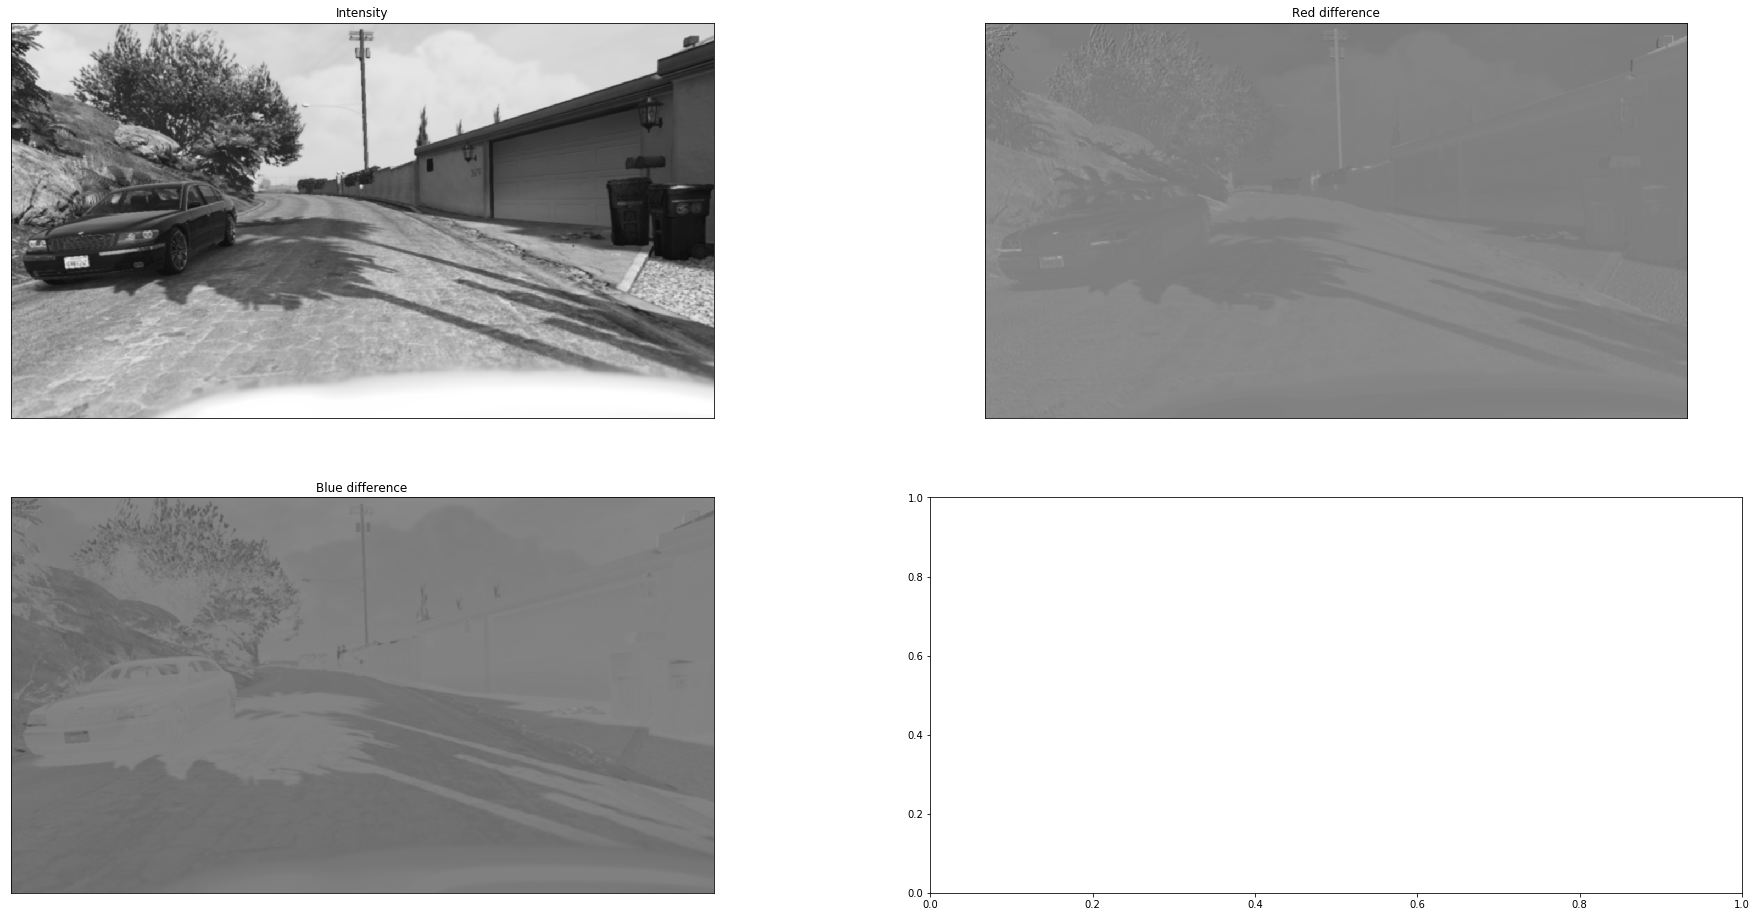

In [4]:
ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb) 
ycc_blur = cv2.GaussianBlur(ycc, (5, 5), 0)
show_array_of_images([ycc_blur], split_channels=True, titles=['Intensity', 'Red difference', 'Blue difference'])

As we'll be carrying out different implementations on each channel, we'll separate them into different arrays

In [5]:
y, cr, cb = cv2.split(ycc_blur)

#### Laws' Mask 

Based on set of slides produced by the Paul G. Allen school of computer science and engineering. [Rao, R.,  2009, Computer Vision Winter 2009, https://courses.cs.washington.edu/courses,pp.12-15](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

The 9 Laws masks are taken by obtaining all possible pair combinations of the four filters below, including self combinations

In [6]:
filters

[array([1, 4, 6, 4, 1]),
 array([-1, -2,  0,  2,  1]),
 array([-1,  0,  2,  0, -1]),
 array([ 1, -4,  6, -4,  1])]

Each combination is a mean of the matrices that are created from the two possible dot products of the two arrays.

In [7]:
show_function(mask)

def mask(image, first, second=None):
    if second is None:
        return cv2.filter2D(image, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(image, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(image, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

Each mask is applied across the image to create a feature array.

All 9 Laws masks are applied to the intensity channel to produce 9 different arrays

In [8]:
show_function(texture_variation)

def texture_variation(image_intensity):
    level, edge, spot, ripple = 0, 1, 2, 3
    masks =  [
                mask(image_intensity, level, edge),
                mask(image_intensity, level, ripple),
                mask(image_intensity, edge, spot),
                mask(image_intensity, spot),
                mask(image_intensity, ripple),
                mask(image_intensity, level, spot),
                mask(image_intensity, edge),
                mask(image_intensity, edge, ripple),
                mask(image_intensity, spot, ripple)
             ]
    
    return np.stack(masks, axis=-1)

The first Laws mask is applied to both the Red difference and Blue differences channels to produce to more features.

In [18]:
show_function(haze)

def haze(cr, cb):
    return np.stack([mask(cr, 0, 1), mask(cb, 0, 1)],axis=-1)

In [19]:
laws = np.concatenate([texture_variation(y),haze(cr, cb)], axis=-1)

In [20]:
laws.shape

(720, 1280, 11)

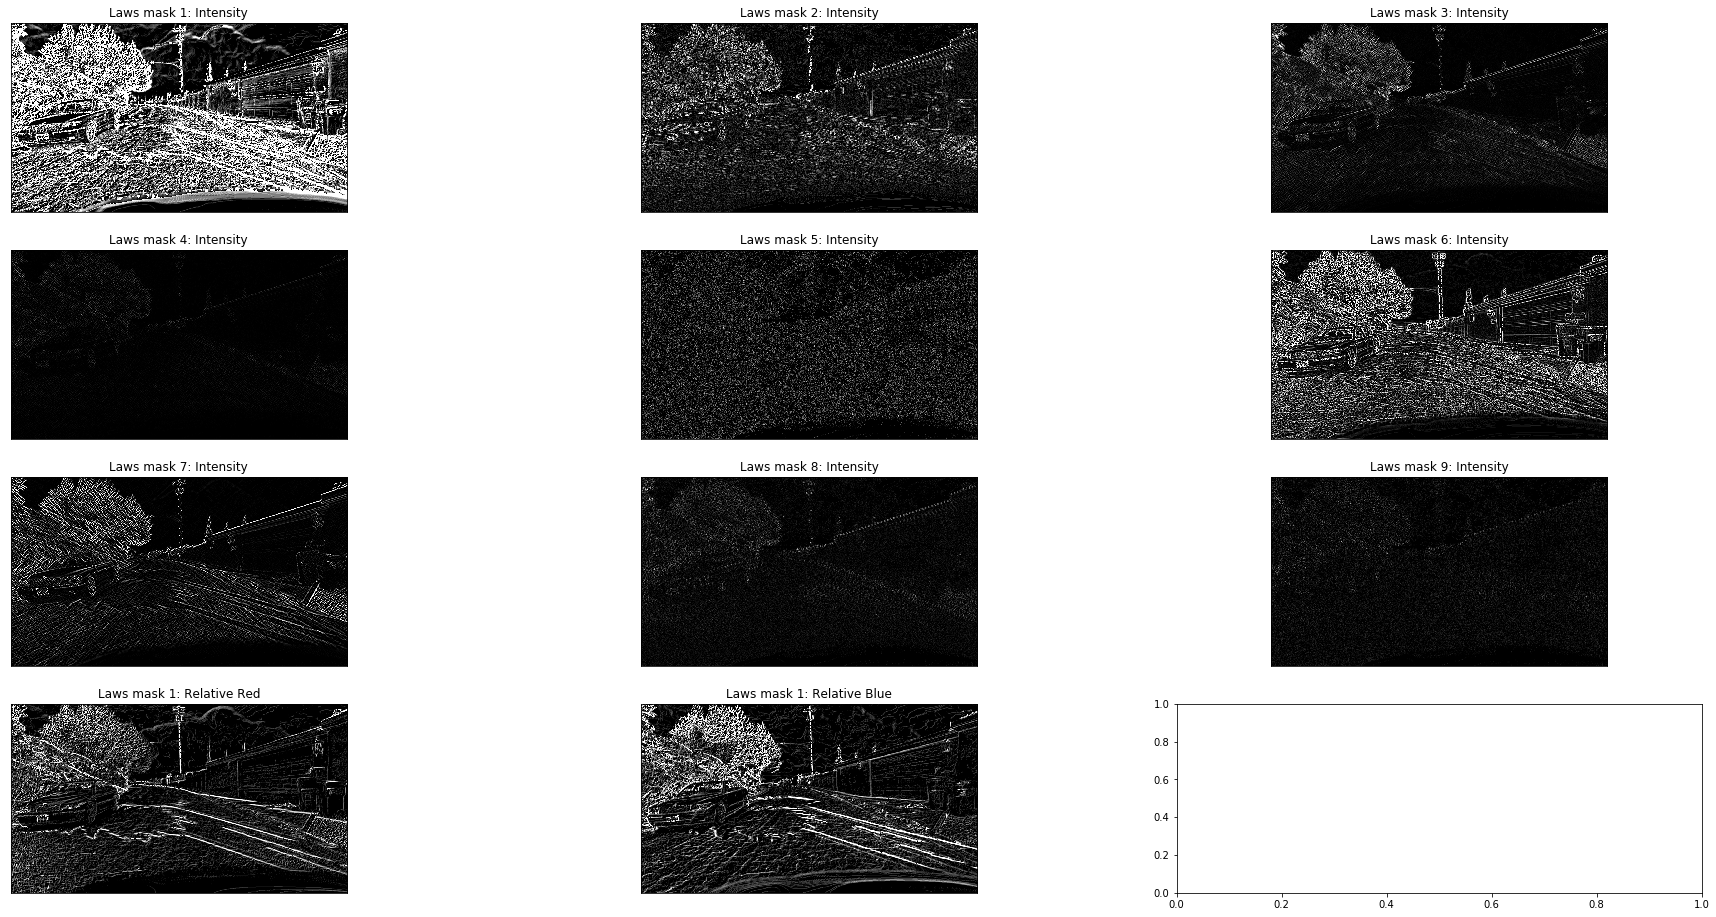

In [21]:
show_array_of_images([laws], split_channels=True, titles=titles[0:11])

#### Edge detection

The current implementation for gradient detection is to use sobel edge detection (implementation taken from Lecture 6: notebook on Hystogram of Gradients) to get the overall edge detection. We then split the edges into bins based on the angle of the gradient.

In [13]:
show_function(texture_gradients)

def texture_gradients(image, d_angle):
    gradX = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
    gradY = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges

    grad = cv2.convertScaleAbs(np.sqrt(gradX**2 + gradY**2))
    angles = np.mod(np.arctan(gradY/(gradX+1e-10)) * 180/np.pi + 180, 180)  # mod() for unsigned gradients 

    axes = np.digitize(angles, np.arange(0,180,d_angle))
    
    # return np.repeat(grad.reshape(*grad.shape,1),6,axis=-1)[axes-1]

    return np.identity((180//d_angle))[axes-1]*grad.reshape(*grad.shape,1)

In [14]:
edges = texture_gradients(y, 30)

In [15]:
edges.shape

(720, 1280, 6)

In [16]:
edges[0][0]

array([0., 0., 0., 0., 0., 0.])

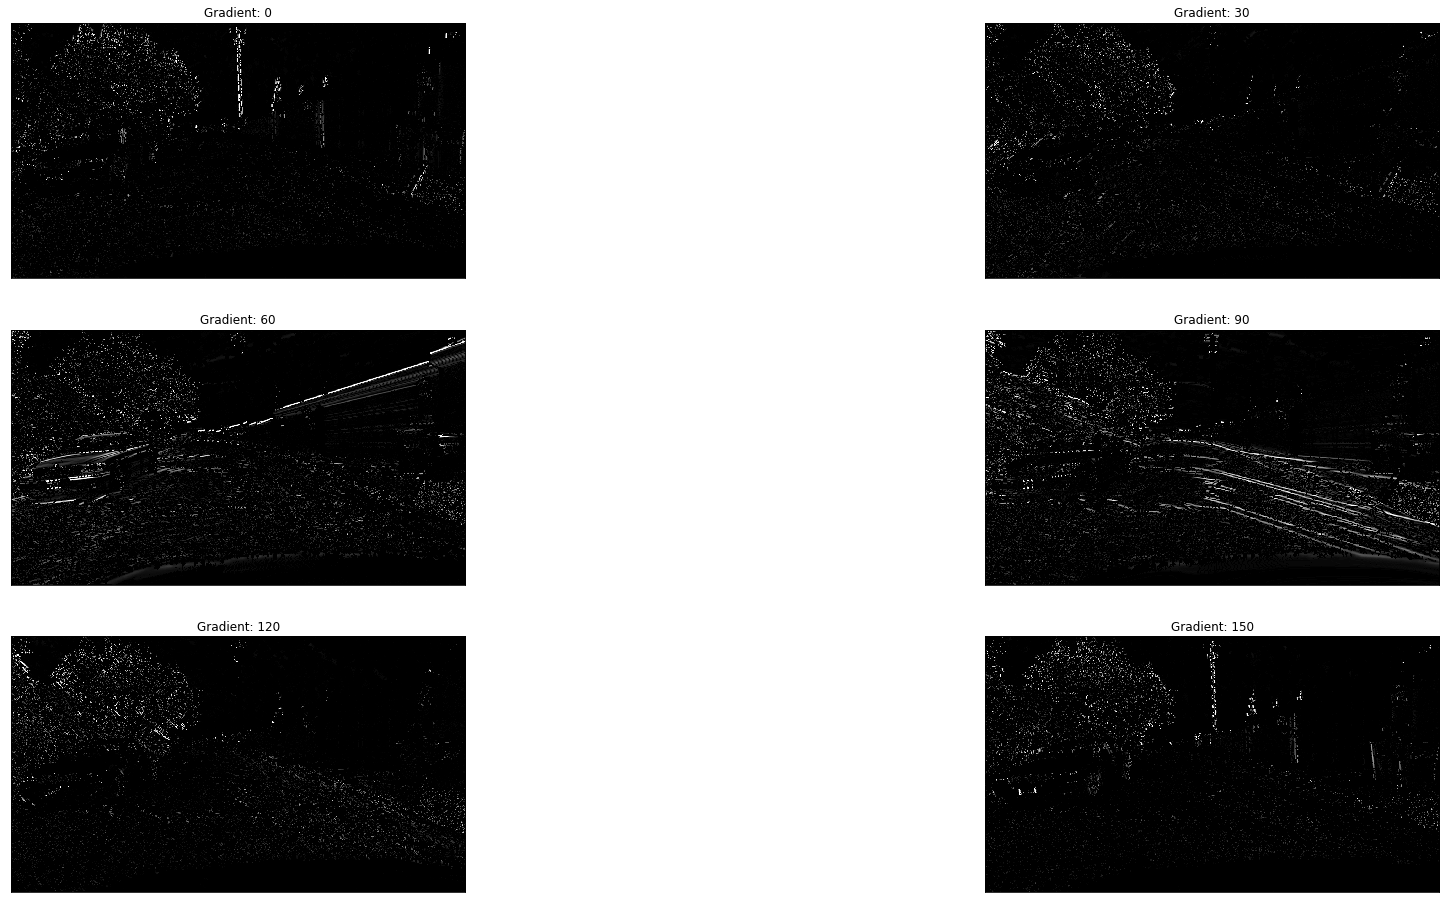

In [17]:
show_array_of_images([edges], split_channels=True,titles = titles[11:])

### Creating a feature array

Below is a function that produces a single array containing all 17 features above. In addition the squares optional parameter can be input as True and the feature array is appended with the square values. By default the values are returned standardised.

In [22]:
show_function(calculate_local_features)

def calculate_local_features(image, convert=None, blur=True, squares=False, std=True):
    if convert is not None:
        image = cv2.cvtColor(image, convert)
    if blur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    y, cr, cb = cv2.split(image)
    
    feature_array = np.concatenate([texture_variation(y),haze(cr,cb),texture_gradients(y, 30)],axis=2)
    
    if squares:
        feature_array = np.concatenate((feature_array, feature_array**2), axis=2)

    if std:
        feature_array = stand(feature_array)

    return feature_array

In [2]:
combined_features = calculate_local_features(bgr, convert=cv2.COLOR_BGR2YCrCb)

In [24]:
combined_features.shape

(720, 1280, 17)

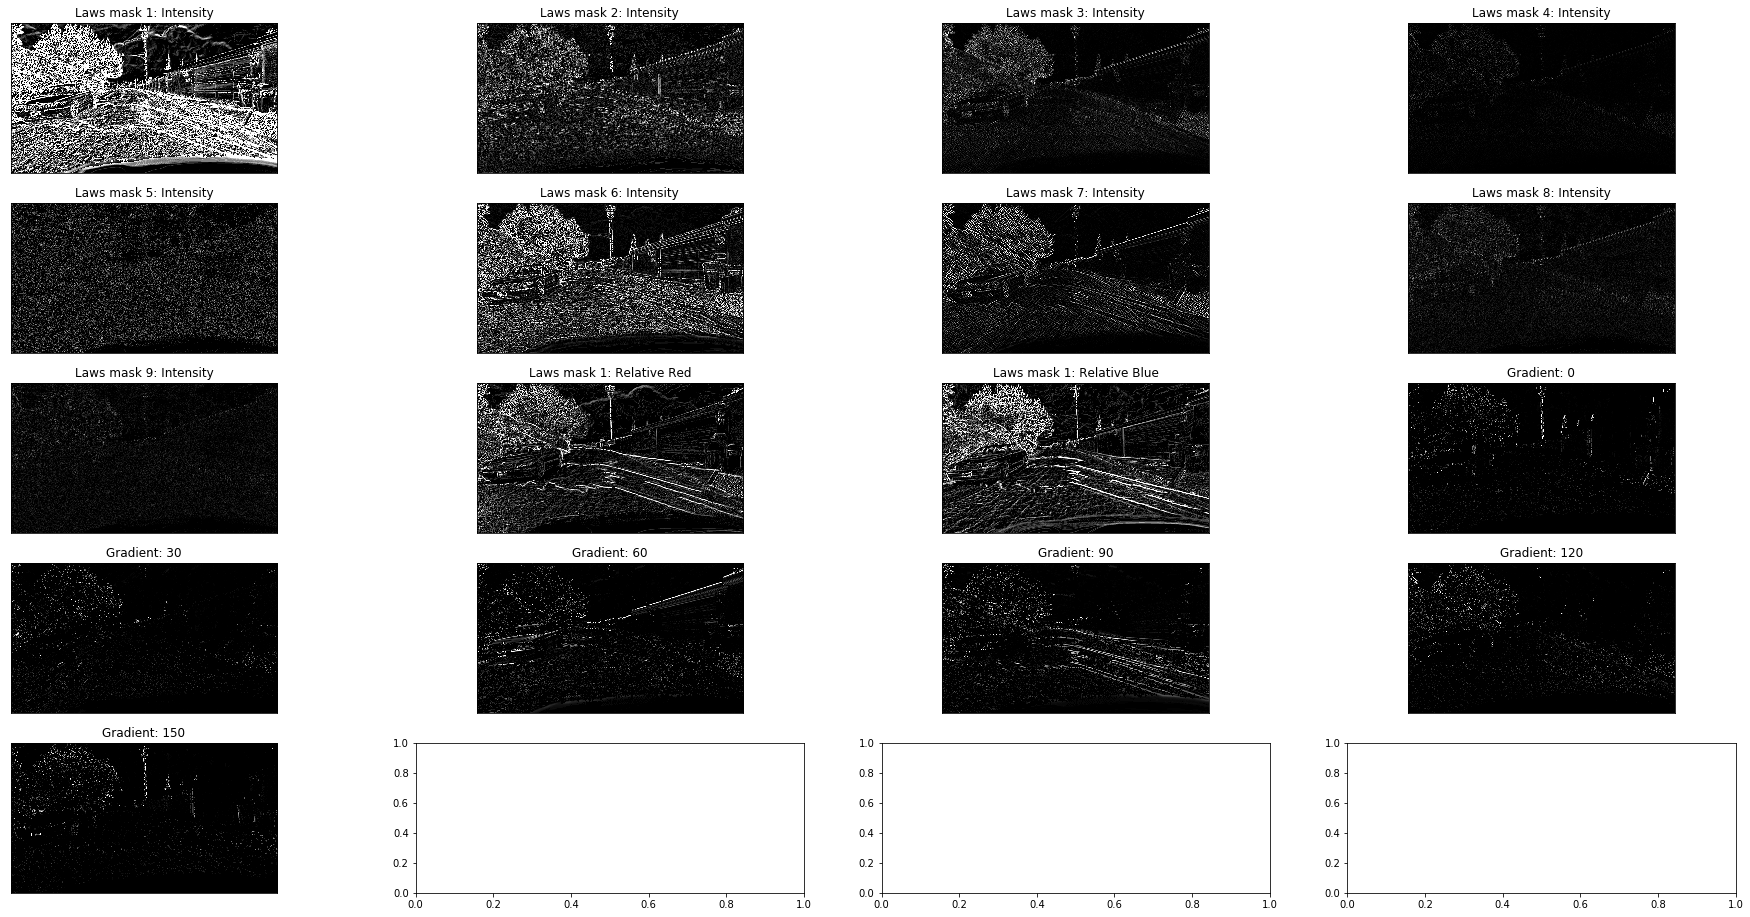

In [25]:
show_array_of_images([combined_features], split_channels=True, titles=titles)

## Global Depth

In addition to the depth approximated for each pixel, additional types of depth information can be utilised:

1. The different scales (patches of size nxm)
1. The the depth of the neighbours of the pixles/patches
1. The relative depth beteen a patch and it's neighbourings patches

### Neighbours

In [26]:
show_function(calc_neighbours)

def calc_neighbours(image, n=1):
    tuples = np.array([(0,0) for i in range(len(image.shape))])
    up    = np.pad(image[:-n],  ((1,0),*tuples[1:]), mode='edge')
    right = np.pad(image[:,n:], ((0,0),(0,1),*tuples[2:]), mode='edge')
    down  = np.pad(image[n:],   ((0,1),*tuples[1:]), mode='edge')
    left  = np.pad(image[:,:-n],((0,0),(1,0),*tuples[2:]), mode='edge')    
    return np.stack([image, up, right, down, left], axis=-2)

In [28]:
neighbours = calc_neighbours(combined_features)

In [29]:
neighbours.shape

(720, 1280, 5, 17)

In [31]:
np.all(neighbours[:,:,0] == combined_features)
np.all(neighbours[0,:,1] == combined_features[0]) and np.all([neighbours[i,:,1] == combined_features[i-1] for i in range(1,neighbours.shape[0])])
np.all(neighbours[:,-1,2] == combined_features[:,-1]) and np.all([neighbours[:,i,2] == combined_features[:,i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[-1,:,3] == combined_features[-1]) and np.all([neighbours[i,:,3] == combined_features[i+1] for i in range(0,neighbours.shape[0]-1)])
np.all(neighbours[:,0,4] == combined_features[:,0]) and np.all([neighbours[:,i,4] == combined_features[:,i-1] for i in range(1,neighbours.shape[0])])

True

True

True

True

True

### Scales

For ease of storing when incorporating scales the image is split into patches. Now instead an array of dimensions of y,x,f, we have py,px,n,f. py and px are the number of patches in the image in that axis, f remains the number of features and n is the sum of the product of the dimenions of the scale of each patch.

In order to get patches of an array we need to ensure the y,x axis are multiples of the y,x patch shape. If not we need to pad the relevant axis.

**n.b. vertical and horizontal behave differently regarding padding. Both use the same padding mode, which in this case is reflect. All padding for rows are added at the top of the image: accurate measurement of the top of the image is less significant as often further away and reflection frequently represents the top of the image better as it often contains sky. The horizontal image looks to spread the excess evenly to left and right sides of the image.**

In [33]:
show_function(patch_pad)

def patch_pad(image, patchshape):
    y_modulus = image.shape[0]%patchshape[0]
    x_modulus = image.shape[1]%patchshape[1]
    
    if y_modulus==x_modulus==0:
        return image

    y_shift = 0 if y_modulus==0 else patchshape[0]-y_modulus
    x_shift = 0 if x_modulus==0 else patchshape[1]-x_modulus
    y_pad = (y_shift,0)
    x_pad = (x_shift//2, math.ceil(x_shift/2))
    # print(y_pad, x_pad)

    empty = [(0,0) for i in range(len(image.shape)-2)]
    return np.pad(image, (y_pad, x_pad, *empty), mode='reflect')

We get a patch by applying a given function, generally np.sum, over each patch. This is simplest done by reshaping the array then applying teh function along the necessary axes.  

All the scales are stored in the same array. The first max_scale*max_scale arrays of the third dimension are the unscaled features. 

In [41]:
show_function(calc_scales)

def calc_scales(image, patch_function, relative_scales):
    t_mul = lambda *tuples : np.product(tuples,axis=0) 
    scales = list(accumulate(relative_scales, t_mul))
    scaled_images = [calc_patches(image, patch_function, scale) for scale in scales]
    if neighbours:
        scaled_images = [calc_neighbours(image) for image in scaled_images]
    return scaled_images

In [42]:
scale_1,scale_3,scale_9 = calc_scales(combined_features, False, np.sum, [(1,1),(3,3),(3,3)])

In [43]:
scale_1.shape 
scale_3.shape 
scale_9.shape 

(720, 1280, 17)

(240, 427, 17)

(80, 143, 17)

For an image shape of 720,1280 and a patchshape of (9,9), the vertical patches will fit exactly but the first horizontal patches will be padded by 3 pixels to the left, 4 to the right.

#### 1x1

In [44]:
np.all(scale_1 == combined_features)

True

#### 3x3

For a scale of 3x3 patches the image will need no vertical padding and pad one pixel to the right of the image. 

In [45]:
'All but last column', np.all([np.round(scale_3[0][i],6) == np.round(np.sum(combined_features[0:3,i*3:i*3+3], axis=(0,1)),6) for i in range(scale_3.shape[1]-1)])
'last column', np.all(np.round(scale_3[0][-1],6) == np.round(np.sum(combined_features[0:3,[-2,-1,-2]], axis=(0,1)),6))

'all rows', np.all([np.round(scale_3[i][0],6) == np.round(np.sum(combined_features[i*3:i*3+3,0:3], axis=(0,1)),6) for i in range(1)])

('All but last column', True)

('last column', True)

('all rows', True)

#### 9x9

For a scale of 3x3 patches the image will need no vertical padding, 3 pixels to the left and 4 to the right.

In [46]:
'first column', np.all(np.round(scale_9[0][0],6) == np.round(np.sum(combined_features[0:9,[*range(1,4),*range(0,6)]], axis=(0,1)),6))
'mid section', np.all([np.round(scale_9[0][i],6) == np.round(np.sum(combined_features[0:9,9*i-3:9*i+6], axis=(0,1)),6) for i in range(1,scale_9.shape[1]-1)])
'last column', np.all(np.round(scale_9[0][-1],6) == np.round(np.sum(combined_features[0:9,[*range(-5,0), *range(-5,-1)]], axis=(0,1)),6))

'all rows', np.all([np.round(scale_9[i][1],6) == np.round(np.sum(combined_features[i*9:i*9+9,6:15], axis=(0,1)),6) for i in range(scale_9.shape[0])])

('first column', True)

('mid section', True)

('last column', True)

('all rows', True)

In [47]:
padded_combined_features = patch_pad(combined_features, (9,9))

In [48]:
padded_combined_features.shape

(720, 1287, 17)

For each scale below the largest there are n values representing each scale, where n is the current scale relative to the largest. In this case it's (3,3), which is represented by 9 elements per patch.

For an image shape of 720,1280 and a patchshape of (3,3), the vertical patches will fit exactly but the first horizontal patches will repeat the far right pixel of each row.

### Relative Histogram

The relative depth between pixels will be 0 (or close to), more information is contained in the difference in depth between patches. We therefore focus on approximating the relative depth between patches.

For estimating the relative depths between patches we take the difference between the histogram of two patches.

In [49]:
show_function(calc_relative_histograms)
show_function(calc_histograms)

def calc_relative_histograms(patches, bins, axis, *kwargs):
    histograms = calc_histograms(patches, bins, axis, *kwargs)
    return calc_relative(histograms)

def calc_histograms(patches, bins, axis):
    bins = bins[:,:-1]
    digitised = np.stack([np.digitize(patches[...,f], bins[f], right=False) for f in range(bins.shape[0])],axis=-1)

    return np.sum(np.identity(bins.shape[-1])[digitised-1], axis=axis)

In [50]:
patches = padded_combined_features.reshape(80,9,143,9,17)

In [51]:
bins = calc_bins(combined_features)

In [52]:
histograms = calc_histograms(patches, bins, axis=(1,3))

In [53]:
histograms.shape

(80, 143, 17, 10)

In [54]:
np.all([histograms[y,x] == [np.histogram(padded_combined_features[9*y:9*y+9,9*x:9*x+9,f], bins=bins[f])[0] for f in range(combined_features.shape[-1])] for y,x in tqdm(product(range(80), range(143)), leave=False, total=80*143)])

True

## Predicting the depth image

For each training image:

1. Calculate the feature array
1. Use least squares to approximate the weights
1. Update the (mean) weights

The prediction is then made using the given function and weights.

**n.b. we calculate the least squares for a log result of a linear function instead of a linear result of an exponential function. This is because the later can often produce a number error due to the size of the number than can be predicted.**

### Scales

When looking to incoporate the different scales the amount of information that needed to be processed in a single least squares function gave no indication of progress after a considerable amount of time. As such it was decided to attempt a route predict the different scales seperately and combine them in a similar way to combining absolute and relative features. A method to do so successfully was not completed in the timeline. As such the current prediction using scaled/relative featuers is significantly less accurate than without.

## Simple collection

**n.b. to convert the values predicted from float to colour values (0-255) the predicted values are normalised over this range. This means that the depth maps provided can be skewed by values larger than 1. As such versions of the depth maps that are capped at 1, which in this case is synonymous with infinity, are provided for better visualisation.**

In [3]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

In [4]:
train_images = colour_images[:-1]
train_labels = depth_images[:-1]
test_image = colour_images[-1]
test_labels = depth_images[-1]

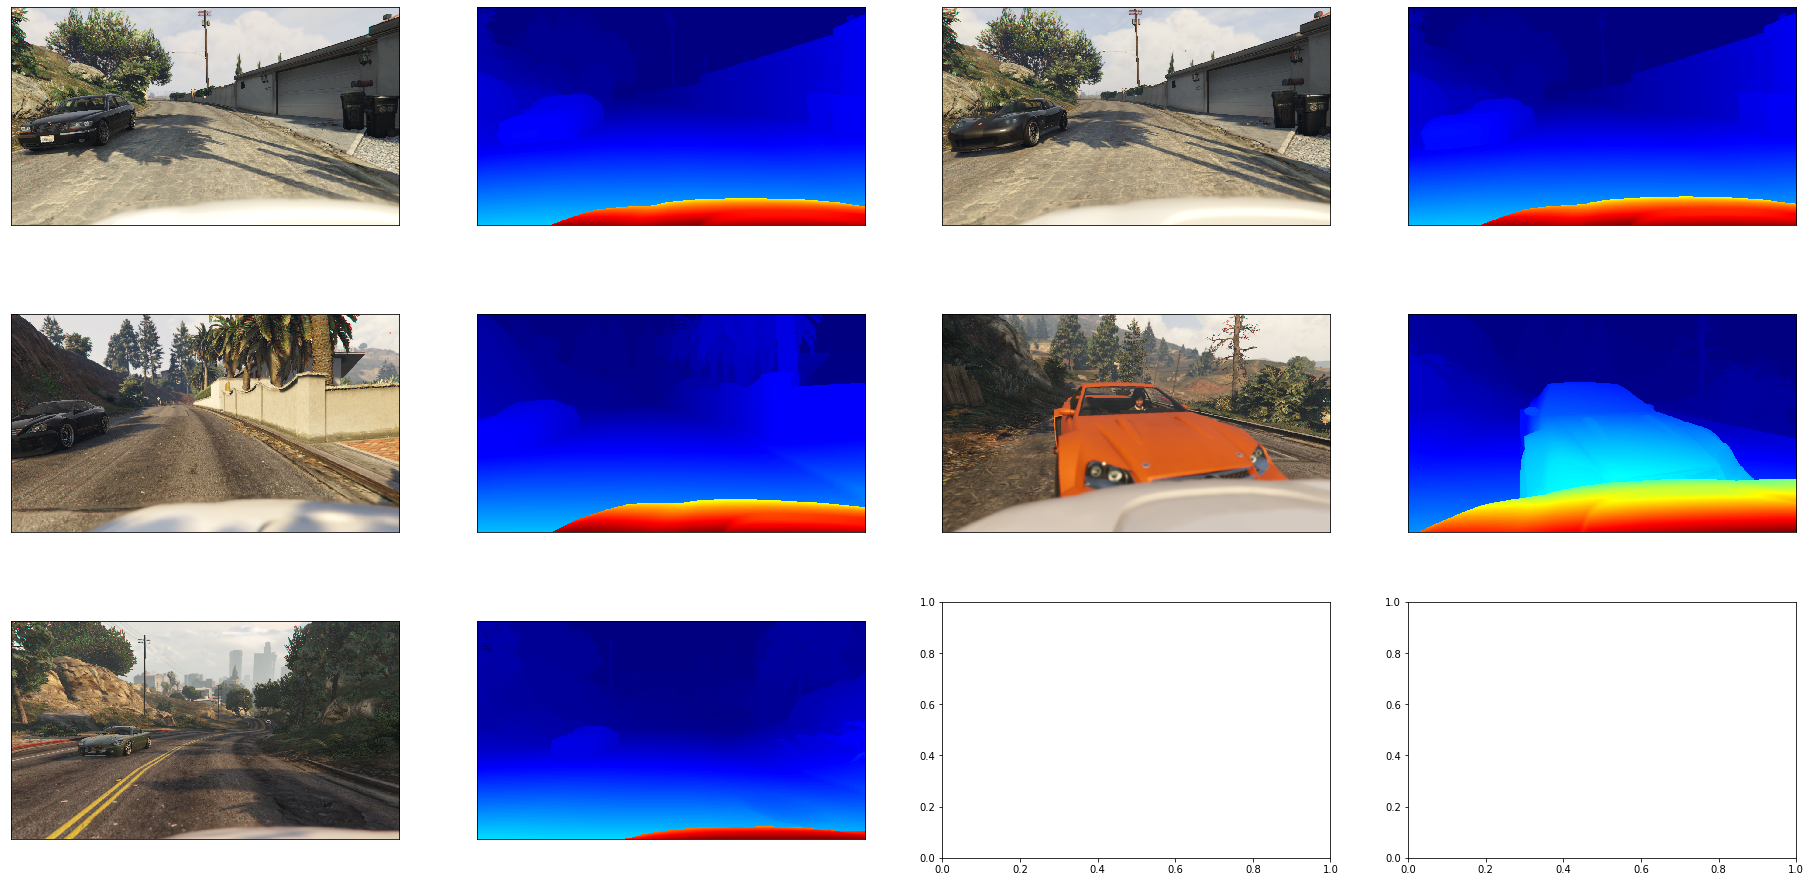

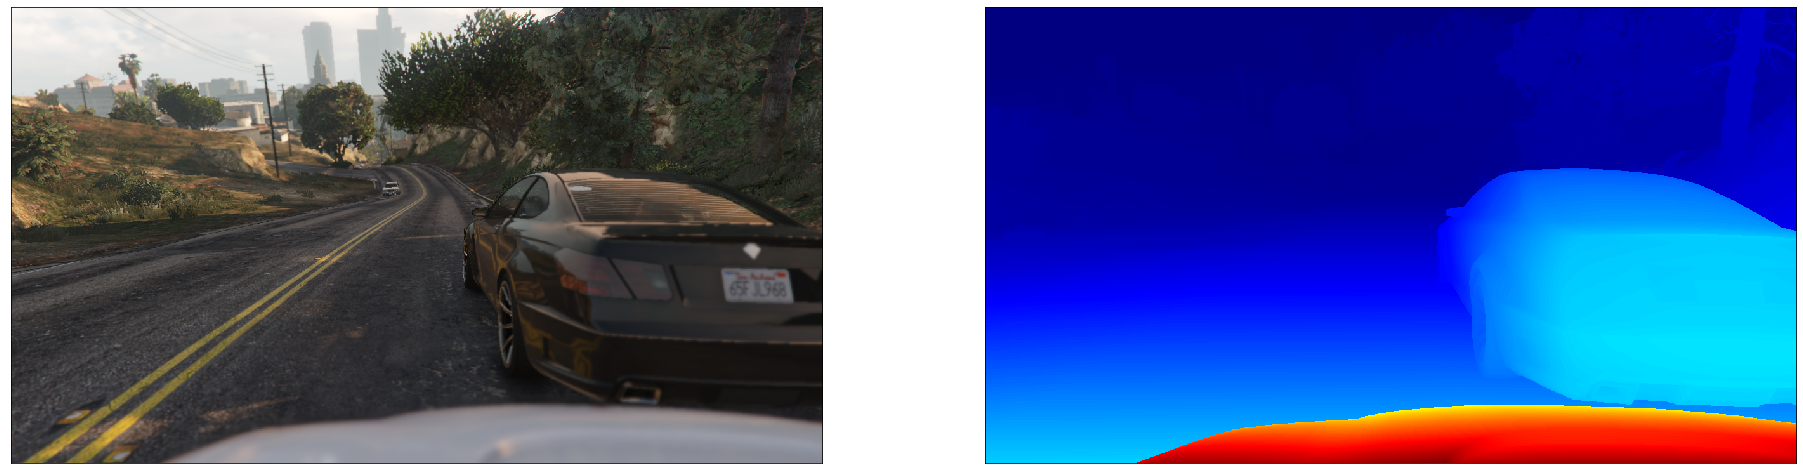

In [5]:
show_array_of_images([x for y in zip(train_images, train_labels) for x in y], image_array_shape=(3,4), depthmap=True)
show_array_of_images([test_image, test_labels], image_array_shape=(1,2), depthmap=True)

### Local

#### Linear

In [30]:
initial_linear_weights = [np.full((1,40,34),1e-4)]

In [31]:
local_linear = Laplacian(initial_linear_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=True), neighbours=False)

In [32]:
local_linear.train(train_images, train_labels, prep=None)

In [33]:
len(local_linear.weights)
local_linear.weights[0].shape

len(local_linear.initial_weights)
local_linear.initial_weights[0].shape

1

(1, 40, 34)

1

(1, 40, 34)

In [34]:
local_linear_prediction = local_linear.predict(test_image, neighbours=False, function=local_linear.linear_function)

In [94]:
local_linear_prediction.shape

(720, 1280)

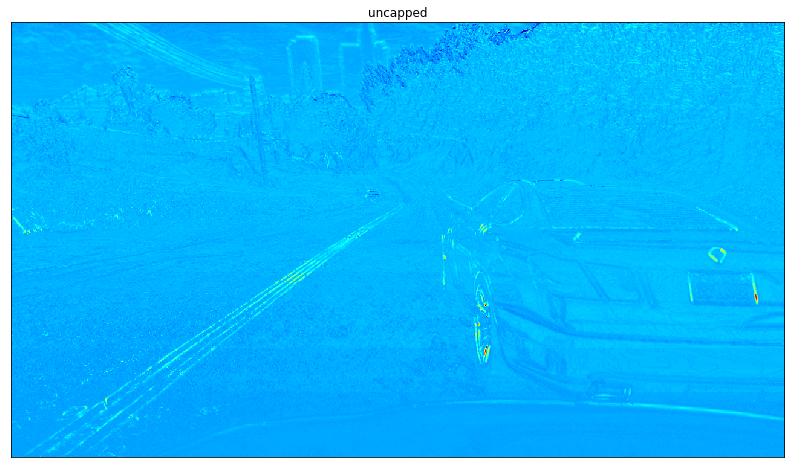

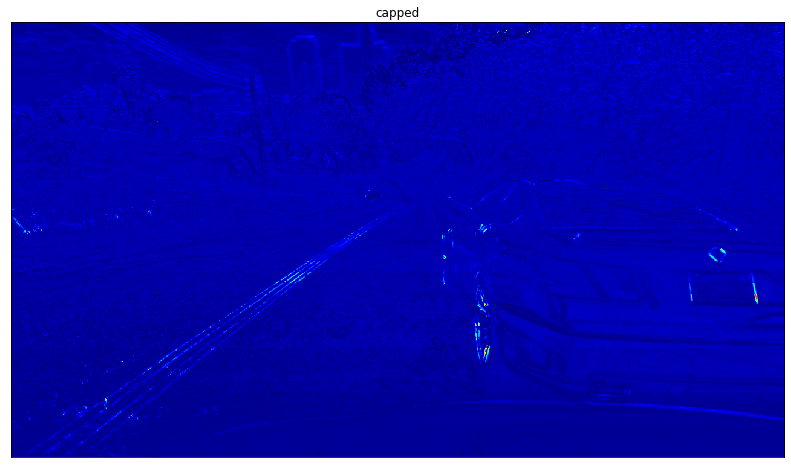

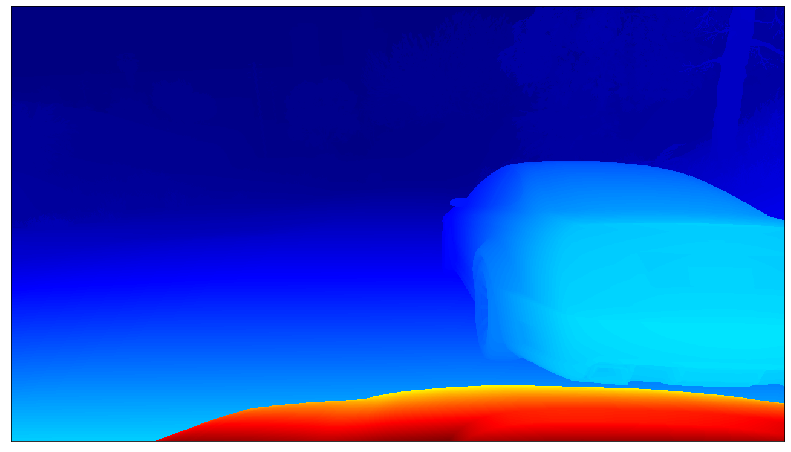

In [95]:
show_img(local_linear_prediction, depthmap=True, title='uncapped')
local_linear_prediction[local_linear_prediction>1]=1
show_img(local_linear_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [96]:
np.sum(np.sqrt((local_linear_prediction - test_labels)**2))

681558.7449145614

## Exponential

**n.b. we calculate the least squares for a log result of a linear function than a linear result of an exponential function.**

In [13]:
initial_exponential_weights = [np.full((1,40, 17), 1e-5)]

In [14]:
local_exponential = Laplacian(initial_exponential_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False)

In [15]:
local_exponential.train(train_images, train_labels, prep=np.log)

In [16]:
local_exponential_prediction = local_exponential.predict(test_image)

In [85]:
local_exponential_prediction.shape

(720, 1280)

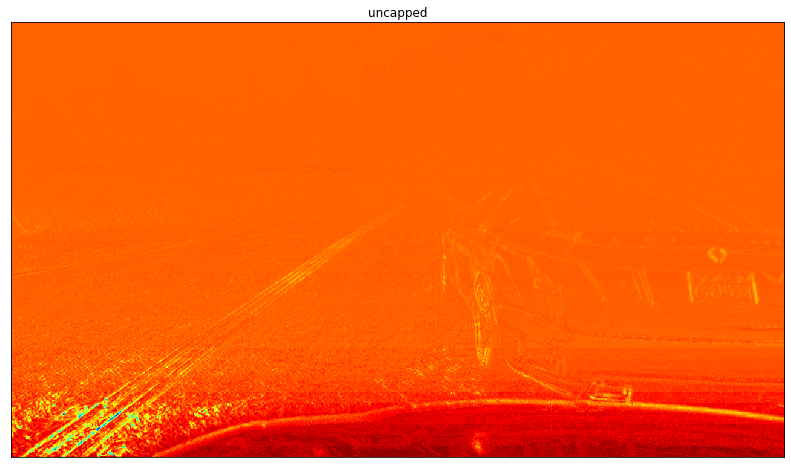

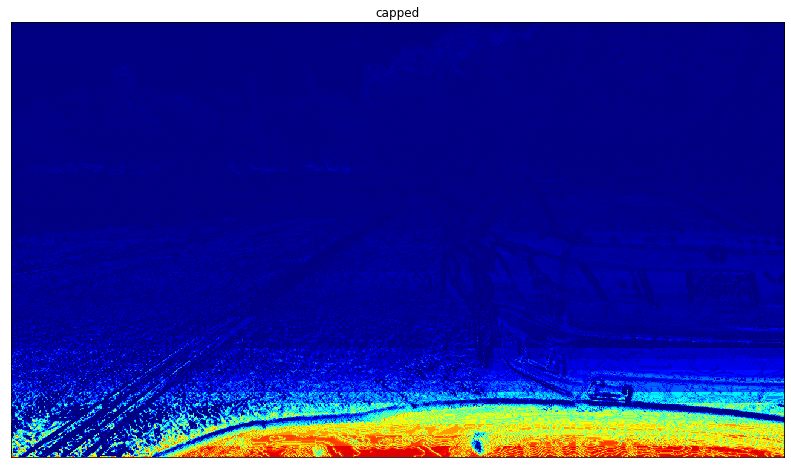

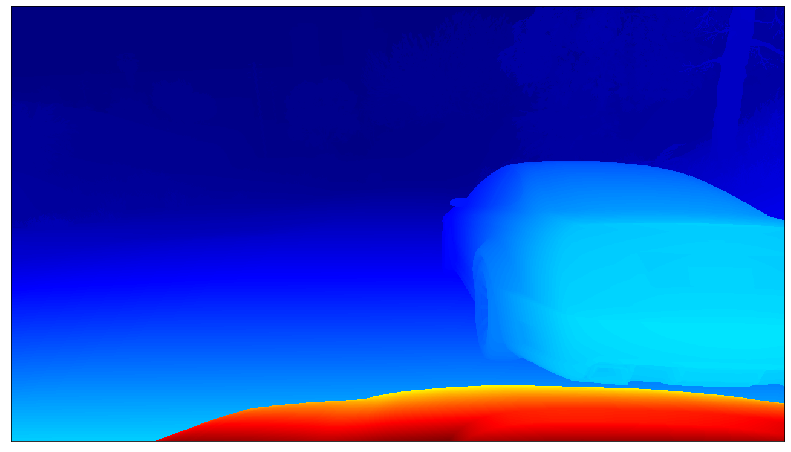

In [86]:
show_img(local_exponential_prediction, depthmap=True, title='uncapped')
local_exponential_prediction[local_exponential_prediction>1]=1
show_img(local_exponential_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [87]:
local_exponential_prediction

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99995717, 1.        ,
        1.        ],
       ...,
       [0.91959567, 0.89361327, 0.89469298, ..., 0.91652121, 0.89475235,
        0.89210194],
       [0.9327219 , 0.88944863, 0.88814521, ..., 0.88301108, 0.88119537,
        0.88119537],
       [0.90031227, 0.88544918, 0.87974056, ..., 0.87200401, 0.87335777,
        0.87335777]])

In [88]:
np.sum(np.sqrt((local_exponential_prediction - test_labels)**2))

13342.833656898196

## Whole Image (Exponential)

In [106]:
whole_image_weights = [np.full((1,1,17), 1e-4)]

In [107]:
whole_image = Laplacian(whole_image_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False)

In [108]:
whole_image.train(train_images, train_labels, prep=np.log)

In [109]:
whole_image_prediction = whole_image.predict(test_image)

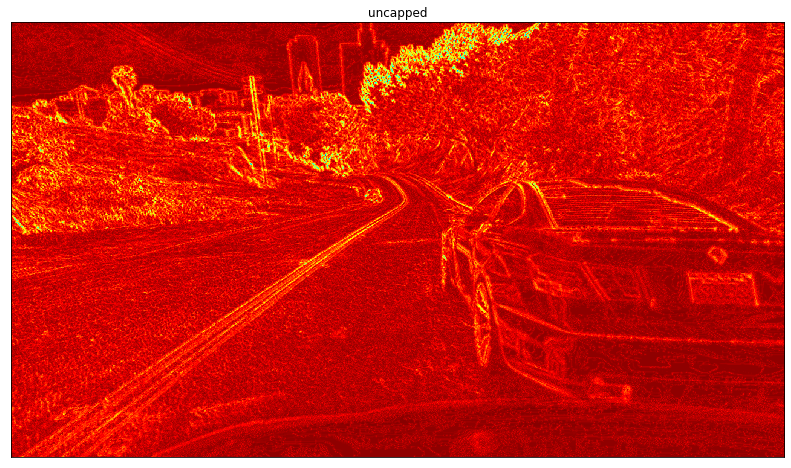

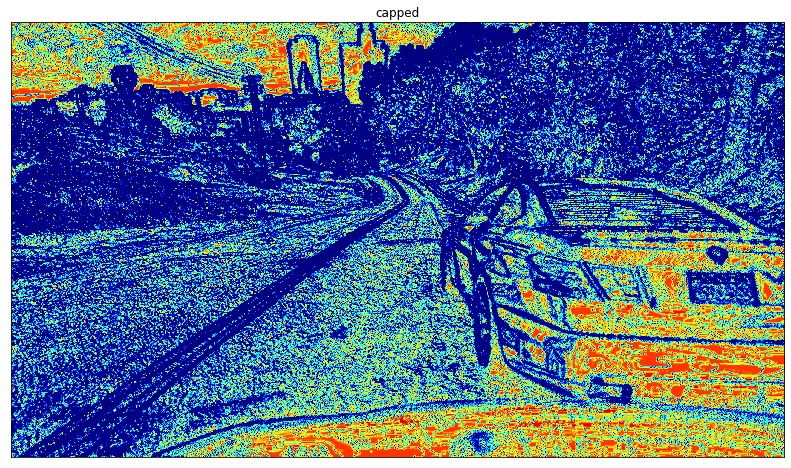

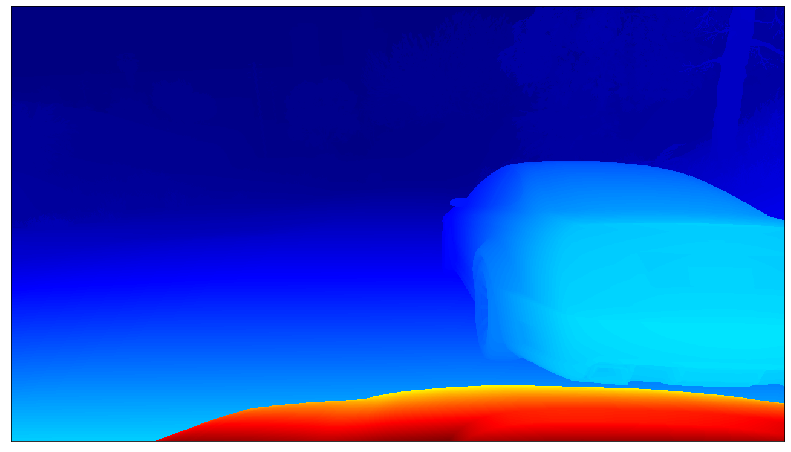

In [110]:
show_img(whole_image_prediction, depthmap=True, title='uncapped')
whole_image_prediction[whole_image_prediction>1]=1
show_img(whole_image_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

## With Neighbours


In [6]:
initial_neighbour_weights = [np.full((1,40, 5*17), 1e-5)]

In [7]:
neighbours = Laplacian(initial_neighbour_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=True)

In [8]:
neighbours.train(train_images, train_labels, prep=np.log)

In [14]:
neighbour_prediction = neighbours.predict(test_image)

In [15]:
neighbour_prediction.shape

(720, 1280)

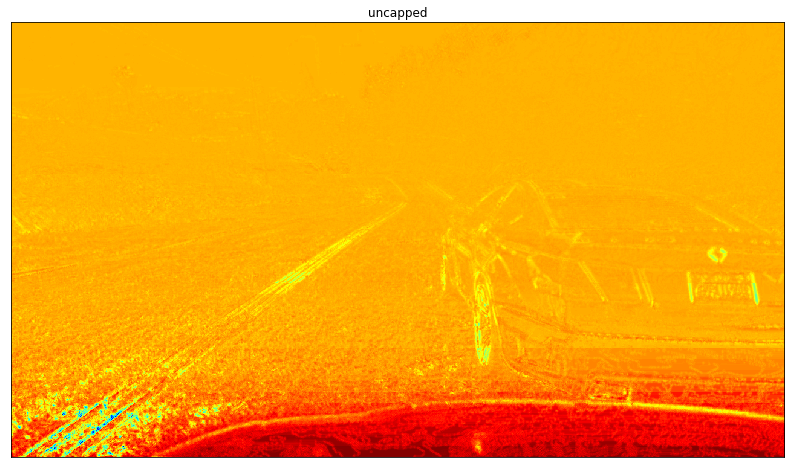

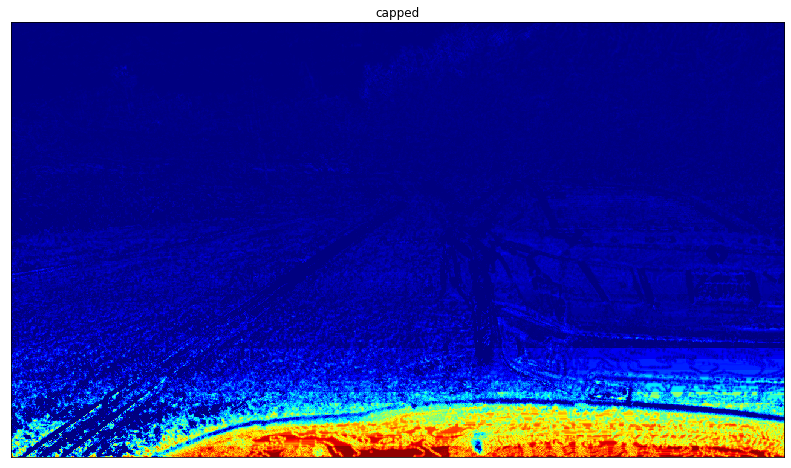

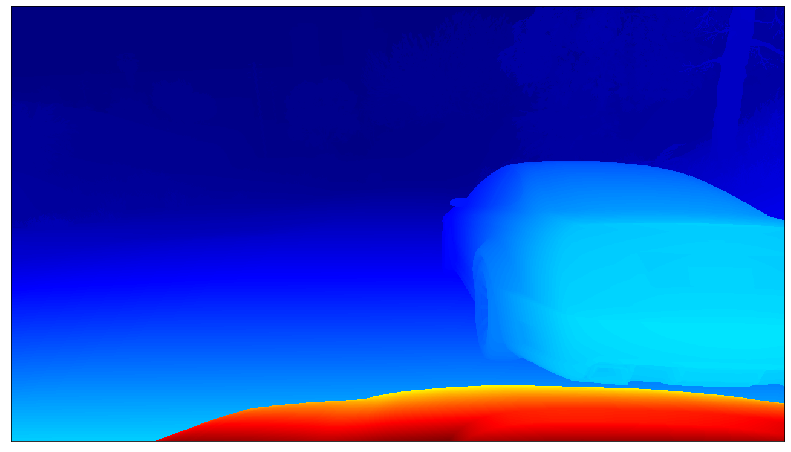

In [16]:
show_img(neighbour_prediction, depthmap=True, title='uncapped')
neighbour_prediction[neighbour_prediction>1]=1
show_img(neighbour_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True)

In [ ]:
neighbour_prediction

In [ ]:
np.sum(np.sqrt((neighbour_prediction - test_labels)**2))

### Global

#### Without Neighbours

In [ ]:
initial_global_weights = [np.full((3,40,17), 1e-4)]
initial_combined_weights = np.full((40,3),1e-4)

In [198]:
global_exponential = Laplacian(initial_global_weights, partial(calculate_local_features, convert=cv2.COLOR_BGR2YCrCb, squares=False), neighbours=False, relative_scales=[(1,1),(3,3),(3,3)], initial_combined_weights=initial_combined_weights)

In [ ]:
global_exponential.train(train_images, train_labels, prep=np.log)

In [ ]:
global_exponential_prediction = global_exponential.predict(test_image)

In [201]:
global_exponential_prediction.shape

(720, 1280)

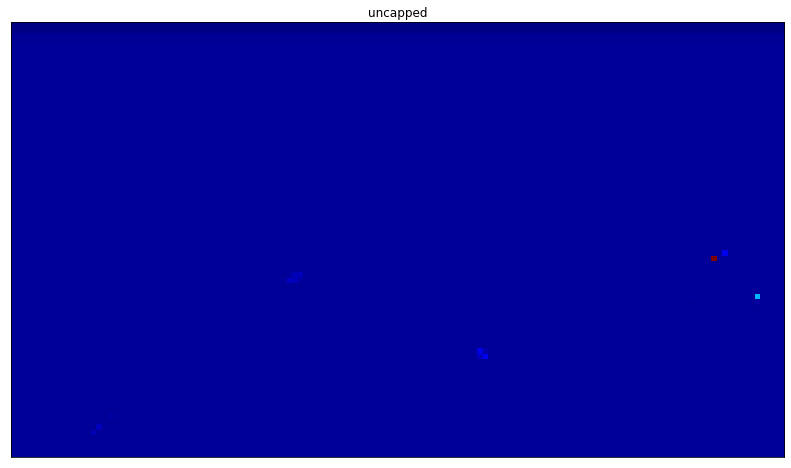

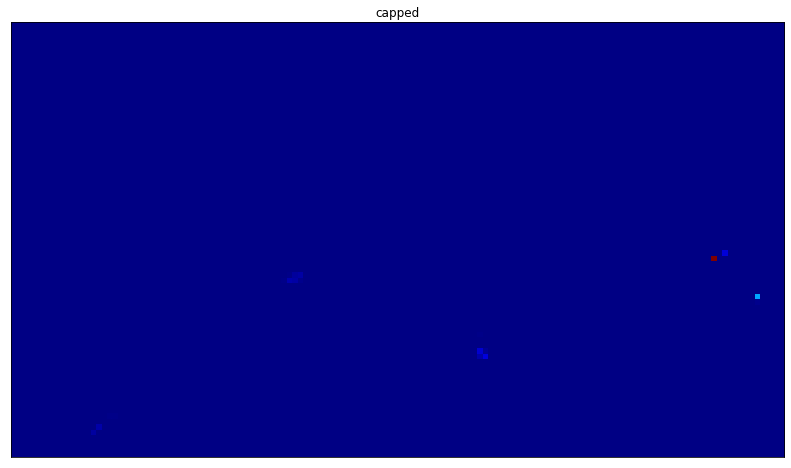

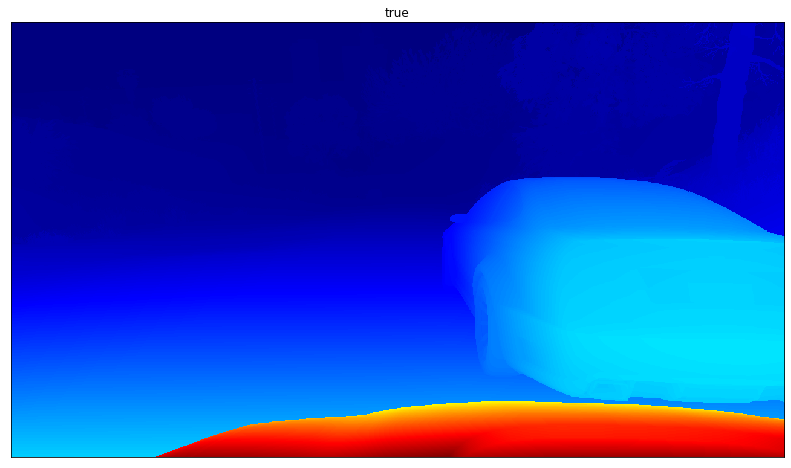

In [202]:
show_img(global_exponential_prediction, depthmap=True, title='uncapped')
global_exponential_prediction[global_exponential_prediction>1]=1
show_img(global_exponential_prediction, depthmap=True, title='capped')
show_img(test_labels, depthmap=True, title='true')

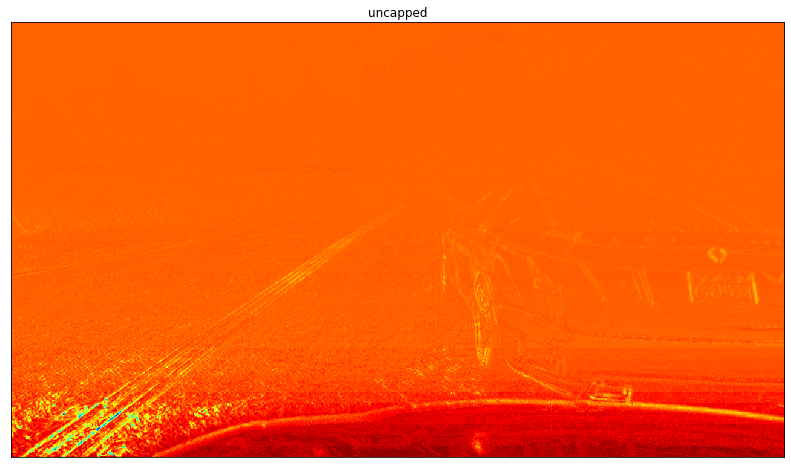

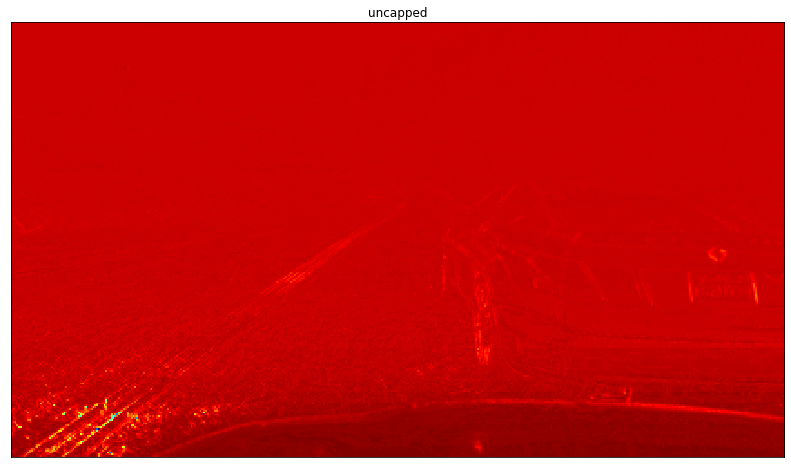

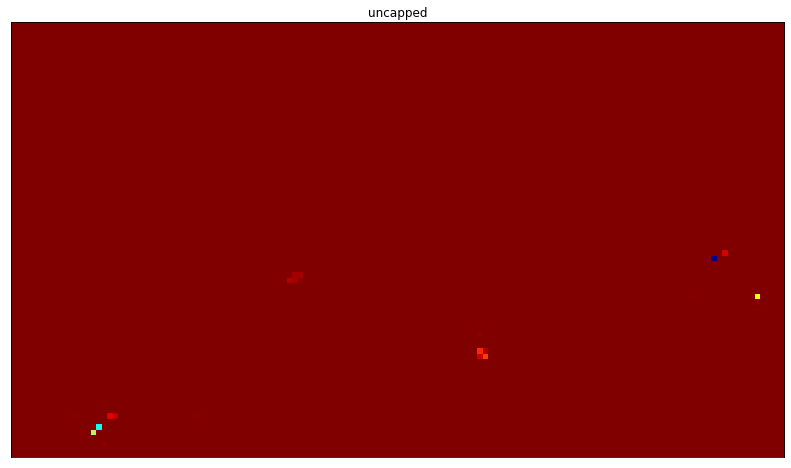

In [165]:
show_img(global_exponential_prediction[...,0], depthmap=True, title='uncapped')
show_img(global_exponential_prediction[...,1], depthmap=True, title='uncapped')
show_img(global_exponential_prediction[...,2], depthmap=True, title='uncapped')

In [154]:
global_exponential_prediction

array([[ 0.00465754,  0.00465754,  0.00465754, ...,  0.00453063,
         0.00452766,  0.00452679],
       [ 0.00466041,  0.00466041,  0.00466041, ...,  0.00452925,
         0.00452734,  0.00452564],
       [ 0.00465971,  0.00465971,  0.00465971, ...,  0.00453316,
         0.00452776,  0.00452433],
       ...,
       [-0.00758302, -0.00734451, -0.00735442, ..., -0.00762794,
        -0.0075487 , -0.00752437],
       [-0.00770352, -0.00730627, -0.00729431, ..., -0.00732032,
        -0.00742424, -0.00742424],
       [-0.007406  , -0.00726956, -0.00721715, ..., -0.00721928,
        -0.00735229, -0.00735229]])

In [28]:
np.sum(np.sqrt((local_exponential_prediction - test_labels)**2))

13342.833656898196

## Conclusion

The features created appear to be a good basis for the approximation of depth. Converting the image channel from colour to YCrCb seems to have been influential in determining the depth using classical techniques. 

There appears to be an exponential relationship between featuers and depth, with functions that assume this to be the case providing predictions on a much more representative scale of the ground truths.

It appears that splitting the image to rows is more accurate than treating the whole image with a single weight. In particular using only one weight means that the sky is predicted to be very near.

Using neighbouring features appears to have some but not a largely significant improvement on the prediction.

## Future Work

Explore the impact of converting an input image to YCrCb colour channels on the ability of a CNN to predict depth

Utilise a method to better incorporate a depth estimation from the combination of arrays (i.e. absolute scales and/or abolute vs relative). Inspiration could come from [Saxena, A., Chung, S.H. and Ng, A.Y., 2008. 3-D depth reconstruction from a single still image. International journal of computer vision, 76(1), pp.53-69.](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) who use least squares to create weights for approximation of the variance based on the calculated features.

The depth values from GTA have a cut off point which means that the sky is recorded at max value. However there seems to be very little difference in depth between objects in the scene and the sky.

A further examination into the size the row combinations should be. It is clear that one weight for all rows is not viable but it also possible that having a weight for each row may make the process less generic as the image model may only be able to accomodate the camera being used at a very specific height and oreientation.